In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import sklearn
import random
import sys
import os
import matplotlib.pyplot as plt
import math
import scipy
from distcorr import distcorr
from fractions import gcd
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [3]:
def normal(x, mu, sigma):
    return (2.*np.pi*sigma**2.)**-.5*np.exp(-.5*(x-mu)**2./sigma**2.)

2000


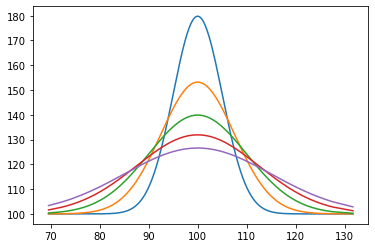

In [4]:
x = []

mu, sigma, n = 100, 10, 2000

np.random.seed(0)
x = np.random.normal(mu, sigma, n)
x.sort()

y = 100 + normal(x, mu, sigma*0.5)*1000
y2 = 100 + normal(x, mu, sigma*0.75)*1000
y3 = 100 + normal(x, mu, sigma*1)*1000
y4 = 100 + normal(x, mu, sigma*1.25)*1000
y5 = 100 + normal(x, mu, sigma*1.5)*1000

print(len(x))

dataset = np.vstack((x, y, y2, y3, y4, y5)).T
plt.plot(dataset[:, 0], dataset[:, 1:])



In [5]:
noise_value = 2

np.random.seed(0)
noise = np.random.normal(0, noise_value, x.shape)
noise2 = np.random.normal(0, noise_value, x.shape)
noise3 = np.random.normal(0, noise_value, x.shape)
noise4 = np.random.normal(0, noise_value, x.shape)
noise5 = np.random.normal(0, noise_value, x.shape)

y_noise = y + noise
y_noise2 = y2 + noise2
y_noise3 = y3 + noise3
y_noise4 = y4 + noise4
y_noise5 = y5 + noise5

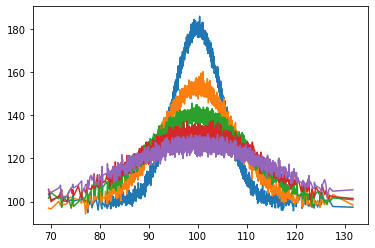

In [6]:
noised_dataset = np.vstack((x, y_noise, y_noise2, y_noise3, y_noise4, y_noise5)).T
plt.plot(noised_dataset[:, 0], noised_dataset[:, 1:])

In [7]:
average_value = np.mean(noised_dataset.flatten())
average_value

124.09768661014816

In [8]:
NAN = 0

def fill_nan(array, REPLACE_COUNT):
    array.flat[np.random.choice(array.size, int(REPLACE_COUNT), replace=False)] = NAN

    return array

In [9]:
full_data = noised_dataset.copy()
missing_data = fill_nan(noised_dataset.copy(), noised_dataset.copy().size*0.2)

In [10]:
bins = np.linspace(0, 10)
y_binned = np.digitize(full_data[:,0], bins)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(missing_data, full_data, stratify=y_binned, random_state=0)

In [12]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = -1
NUM_FEATURES = 6
BATCH_SIZE_TEST = -1

In [13]:
x_train = torch.from_numpy(x_train)
#x_train = x_train.to(device)
x_train = x_train.view(BATCH_SIZE, NUM_FEATURES)

y_train = torch.from_numpy(y_train)
#y_train = y_train.to(device)
y_train = y_train.view(BATCH_SIZE, NUM_FEATURES)

x_test = torch.from_numpy(x_test)
#x_test = x_test.to(device)
x_test = x_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

y_test = torch.from_numpy(y_test)
#y_test = y_test.to(device)
y_test = y_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

x_train.shape

torch.Size([1500, 6])

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=6, out_features=8)
        self.enc2 = nn.Linear(in_features=8, out_features=16)

        self.dec2 = nn.Linear(in_features=16, out_features=8)
        self.dec3 = nn.Linear(in_features=8, out_features=6)

    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        x = F.leaky_relu(self.dec2(x))
        x = self.dec3(x)
        return x

In [15]:
# CREATE A SEED FOR CONSISTENT WEIGHT INITIALIZATIONS - FOR TESTING PURPOSES
random.seed(2)
torch.manual_seed(random.randint(1, 10))
net = Autoencoder().double()
#net.to(device)

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [17]:
def train(net):
    train_loss = []
    torch.set_printoptions(precision=2, sci_mode=False)
    np.set_printoptions(precision=2, suppress=True)

    for epoch in range(NUM_EPOCHS):
        # running_loss: LOSS OF THE PREDICTED MISSING VALUE ONLY
        # overall_loss: LOSS OF ALL RECONSTRUCTED VALUES

        running_loss = 0.0
        overall_loss = 0.0
        count = 0
        for missing_data, full_data in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
            
            # COMPUTE LOSS OF PREDICTED MISSING VALUE
            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            # PRINT ALL VALUES ON LAST EPOCH FOR TESTING PURPOSES
            if epoch == NUM_EPOCHS-1:
                if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                    print("Input: ", missing_data)
                    print("Target: ", full_data)
                    print("Outputs: ", outputs)
                else:
                    print("Input (missing): ", missing_data)
                    print("Target (missing): ", full_data)
                    print("Outputs (missing): ", outputs)
        
      #  loss = running_loss / count
        overall_loss = overall_loss / len(x_train)
        x_loss = running_loss / count
        train_loss.append(loss)



        print('Epoch {} of {}, Train Loss: {:.5f}, Overall: {:.5f}'
             .format(epoch+1, NUM_EPOCHS, x_loss, overall_loss))

    return train_loss


def test(net):

    net.eval()
    count = 0

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0
        overall_loss = 0.0

        for missing_data, full_data in zip(x_test, y_test):
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            overall_loss += loss.item()

            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                print("Input: ", missing_data)
                print("Target: ", full_data)
                print("Outputs: ", outputs)
            else:
                print("Input (missing): ", missing_data)
                print("Target (missing): ", full_data)
                print("Outputs (missing): ", outputs)

        overall_loss = overall_loss / len(x_test)
        x_loss = running_loss / count
        test_loss.append(overall_loss)
        

        return test_lossprint('Test Loss: {:.3f}, Overall: {:.5f}'.format(x_loss, overall_loss))

In [41]:
results2 = train(net)

ype=torch.float64,
       grad_fn=<AddBackward0>)
Input (missing):  tensor([111.43,   0.00, 114.20, 117.60, 121.35, 119.44], dtype=torch.float64)
Target (missing):  tensor([111.43, 107.06, 114.20, 117.60, 121.35, 119.44], dtype=torch.float64)
Outputs (missing):  tensor([104.94, 105.88, 114.65, 117.79, 120.03, 119.42], dtype=torch.float64,
       grad_fn=<AddBackward0>)
Input (missing):  tensor([  0.00, 110.20, 118.12, 124.53,   0.00, 121.33], dtype=torch.float64)
Target (missing):  tensor([110.22, 110.20, 118.12, 124.53, 124.32, 121.33], dtype=torch.float64)
Outputs (missing):  tensor([103.31, 109.70, 121.43, 124.72, 124.60, 123.46], dtype=torch.float64,
       grad_fn=<AddBackward0>)
Input (missing):  tensor([ 94.18,   0.00, 135.44, 134.69, 125.41, 124.52], dtype=torch.float64)
Target (missing):  tensor([ 94.18, 139.17, 135.44, 134.69, 125.41, 124.52], dtype=torch.float64)
Outputs (missing):  tensor([ 93.09, 138.14, 134.88, 129.92, 126.43, 121.92], dtype=torch.float64,
       grad_fn=

In [26]:
test_result = test(net)

 119.37], dtype=torch.float64)
Target (missing):  tensor([ 92.40, 120.58, 129.46, 131.70, 125.82, 119.37], dtype=torch.float64)
Outputs (missing):  tensor([ 94.75, 119.86, 119.37, 117.10, 113.96, 112.25], dtype=torch.float64)
Input (missing):  tensor([  0.00, 181.99, 152.44, 142.46, 131.81, 126.67], dtype=torch.float64)
Target (missing):  tensor([ 99.39, 181.99, 152.44, 142.46, 131.81, 126.67], dtype=torch.float64)
Outputs (missing):  tensor([111.59, 179.57, 157.25, 145.38, 136.33, 131.32], dtype=torch.float64)
Input (missing):  tensor([ 96.59, 163.86, 143.94, 137.10, 129.36,   0.00], dtype=torch.float64)
Target (missing):  tensor([ 96.59, 163.86, 143.94, 137.10, 129.36, 127.79], dtype=torch.float64)
Outputs (missing):  tensor([ 97.07, 160.52, 146.98, 137.52, 129.81, 125.15], dtype=torch.float64)
Input (missing):  tensor([ 82.17,   0.00, 105.71, 107.98, 111.57,   0.00], dtype=torch.float64)
Target (missing):  tensor([ 82.17,  99.78, 105.71, 107.98, 111.57, 114.87], dtype=torch.float64)

In [27]:
torch.save(net, './model4')

In [18]:
net = torch.load('model4')
net

Autoencoder(
  (enc1): Linear(in_features=6, out_features=8, bias=True)
  (enc2): Linear(in_features=8, out_features=16, bias=True)
  (dec2): Linear(in_features=16, out_features=8, bias=True)
  (dec3): Linear(in_features=8, out_features=6, bias=True)
)

In [19]:
predicted_set = net(x_test.double())
predicted_set = predicted_set.detach().numpy()

real_set = y_test.detach().numpy()

In [20]:
real_values = []
predicted_values = []
x_values = []

for missing_data, full_data, predicted in zip(x_test, y_test, predicted_set):
    if NAN in missing_data:
        for i in range(len(missing_data)):
            if missing_data[i] == NAN:
                x_values.append(full_data[0].item())
                real_values.append(full_data[i].item())
                predicted_values.append(predicted[i].item())

In [26]:
from scipy import stats
from statsmodels.stats import weightstats as stets

p_values = []
t_values = []

for i in range(6):
    ttest, pval = stats.ttest_ind(real_set[:, i], predicted_set[:, i])
    print("P-value for significance: ", pval)
    print("TTEST: ", ttest)
    p_values.append(pval)
    t_values.append(ttest)

    if pval<0.05:
        print("Conclusion: Reject Null Hypothesis")
    else:
        print("Conclusion: Accept Null Hypothesis")

print("Mean P-Value: ", np.mean(p_values))
print("Mean T-Value: ", np.mean(t_values))

P-value for significance:  2.7674276525903713e-06
TTEST:  -4.714475768881493
Conclusion: Reject Null Hypothesis
P-value for significance:  0.18399806206567804
TTEST:  1.3294660581248774
Conclusion: Accept Null Hypothesis
P-value for significance:  0.3259403957695308
TTEST:  0.9828074742698815
Conclusion: Accept Null Hypothesis
P-value for significance:  0.4105701961873288
TTEST:  0.8232364797327713
Conclusion: Accept Null Hypothesis
P-value for significance:  0.003399075132442955
TTEST:  2.9361791182830212
Conclusion: Reject Null Hypothesis
P-value for significance:  0.006741060882911987
TTEST:  2.7150444014507906
Conclusion: Reject Null Hypothesis
Mean P-Value:  0.1551085929109242
Mean T-Value:  0.6787096271633081


In [43]:
for i in range(1, 6):
    print('Original Column: ', i, distcorr(real_set[:, 0], real_set[:, i]))
    print('Predicted Column: ', i,  distcorr(real_set[:, 0], predicted_set[:, i]))

Original Column:  1 0.5477929382341967
Predicted Column:  1 0.5371078376609566
Original Column:  2 0.5604636019245646
Predicted Column:  2 0.5506383663192703
Original Column:  3 0.5544976849812032
Predicted Column:  3 0.5434253711532975
Original Column:  4 0.532549978072888
Predicted Column:  4 0.5127502399857481
Original Column:  5 0.4989438002147016
Predicted Column:  5 0.48264858753542067


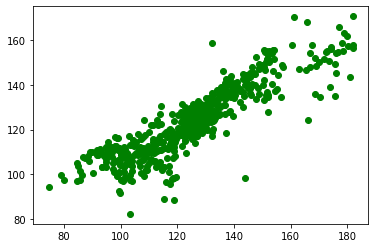

In [27]:
plt.scatter(real_values, predicted_values, color='green')
plt.show()

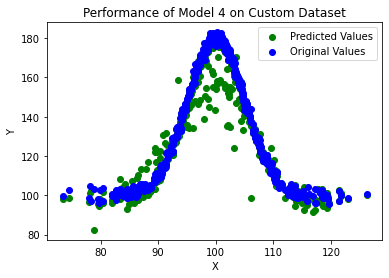

In [30]:
plt.scatter(y_test[:,0], predicted_set[:, 1], color='green', label='Predicted Values')
plt.scatter(y_test[:,0], y_test[:, 1], color='blue', label='Original Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Performance of Model 4 on Custom Dataset')
plt.show()

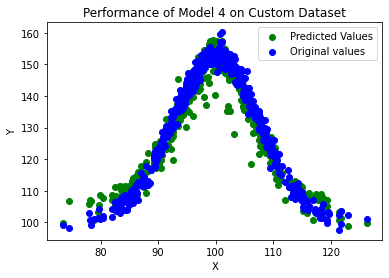

In [31]:
plt.scatter(y_test[:, 0], predicted_set[:, 2], color='green', label='Predicted Values')
plt.scatter(y_test[:, 0], y_test[:, 2], color='blue', label='Original values')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Performance of Model 4 on Custom Dataset')
plt.show()

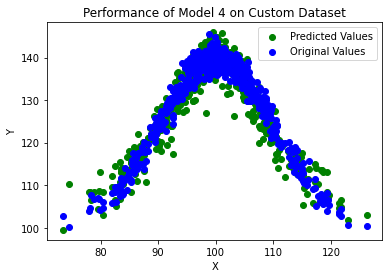

In [32]:
plt.scatter(y_test[:,0], predicted_set[:, 3], color='green', label='Predicted Values')
plt.scatter(y_test[:,0], y_test[:, 3], color='blue', label='Original Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Performance of Model 4 on Custom Dataset')
plt.show()

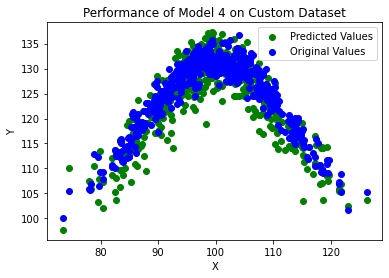

In [33]:
plt.scatter(y_test[:,0], predicted_set[:, 4], color='green', label='Predicted Values')
plt.scatter(y_test[:,0], y_test[:, 4], color='blue', label='Original Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Performance of Model 4 on Custom Dataset')
plt.show()

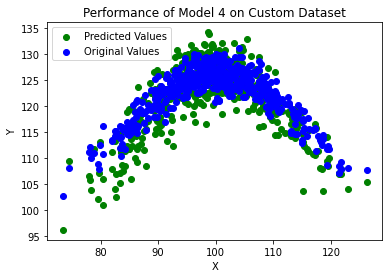

In [34]:
plt.scatter(y_test[:,0], predicted_set[:, 5], color='green', label='Predicted Values')
plt.scatter(y_test[:,0], y_test[:, 5], color='blue', label='Original Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Performance of Model 4 on Custom Dataset')
plt.show()